<a href="https://colab.research.google.com/github/Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision/blob/main/notebooks/Human_Emotion_Detection_using_EfficientNetB4_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Human Emotion Detection: Fine-Tuning EfficientNetB4
===================================================

In this notebook, we implement fine-tuning on the EfficientNetB4 model to enhance its ability to detect human emotions. Fine-tuning is a powerful technique in transfer learning, combining the strengths of pre-trained models with the adaptability required for specific tasks. This approach involves training additional custom layers initially, then gradually unfreezing and fine-tuning the pre-trained backbone.

**Introduction to Fine-Tuning**
-------------------------------

Fine-tuning builds upon a previously trained model. Initially, the pre-trained model is frozen, meaning its weights remain unchanged, and only the added custom layers are trained. This ensures that the model utilizes the general features it learned from a large-scale dataset (like ImageNet). Subsequently, the backbone is unfrozen, and its layers are trained at a lower learning rate to adapt to the new task while retaining its foundational knowledge.

**Step-by-Step Explanation**
----------------------------

### **1\. Revisiting the Pre-Trained Model**

The process begins with incorporating the EfficientNetB4 backbone, a model pre-trained on the ImageNet dataset.

*   The backbone is loaded with the parameter include\_top=False, excluding the top layers specific to ImageNet classification.
    
*   The model's weights are initialized with those from ImageNet, ensuring access to rich, general-purpose features.
    
*   The input shape is defined based on the dataset's image size, ensuring compatibility with the pre-trained model.
    
*   Initially, the backbone is frozen by setting backbone.trainable = False to retain its pre-trained knowledge and prevent overfitting during the initial training stages.
    

### **2\. Building the Model (Initial Phase)**

The initial model is built with the following components:

*   **Input Layer**: Specifies the input shape matching the requirements of the pre-trained backbone.
    
*   **EfficientNetB4 Backbone**: Acts as the feature extractor, producing high-level feature maps from the input images.
    
*   **Global Average Pooling Layer**: Reduces the spatial dimensions of the feature maps, transforming them into a single feature vector per channel.
    
*   **Dense Layers**: Two fully connected layers are added with ReLU activation for learning task-specific features. The first dense layer's size is determined by CONFIGURATION\["N\_DENSE\_1"\], while the second dense layer is defined by CONFIGURATION\["N\_DENSE\_2"\].
    
*   **Batch Normalization**: Applied after the dense layers to normalize activations, improving stability and speeding up convergence during training.
    
*   **Output Layer**: A dense layer with softmax activation maps the extracted features to class probabilities. The number of classes corresponds to CONFIGURATION\["NUM\_CLASSES"\].
    

In this phase, the backbone is frozen, and only the added layers are trained.

### **3\. Transitioning to Fine-Tuning**

After the initial training with a frozen backbone, the fine-tuning process is initiated to adapt the model more effectively to the task:

*   The backbone is unfrozen (backbone.trainable = True), allowing all layers of the pre-trained model to be trained.
    
*   A new model architecture is created using the Functional API, which offers enhanced flexibility and control compared to the Sequential API.
    

### **4\. Building the Model (Fine-Tuning Phase)**

In this phase, a more advanced architecture is implemented using the Functional API:

*   **Input Layer**: Defines the shape of the input images, which serves as the starting point for the Functional API model.
    
*   **Backbone Layer**: The pre-trained EfficientNetB4 processes the input images. To ensure stable activations, the training=False argument is used in the backbone to keep batch normalization layers in inference mode.
    
*   **Global Average Pooling Layer**: Converts the spatially reduced feature maps into a single feature vector per channel.
    
*   **Dense and Batch Normalization Layers**: Dense layers with ReLU activation are added to extract task-specific patterns. Batch normalization is applied after these layers to normalize activations and improve stability.
    
*   **Output Layer**: A dense layer with softmax activation maps the final feature representation to class probabilities for each emotion class.
    

Finally, the model is compiled by connecting the input and output layers.

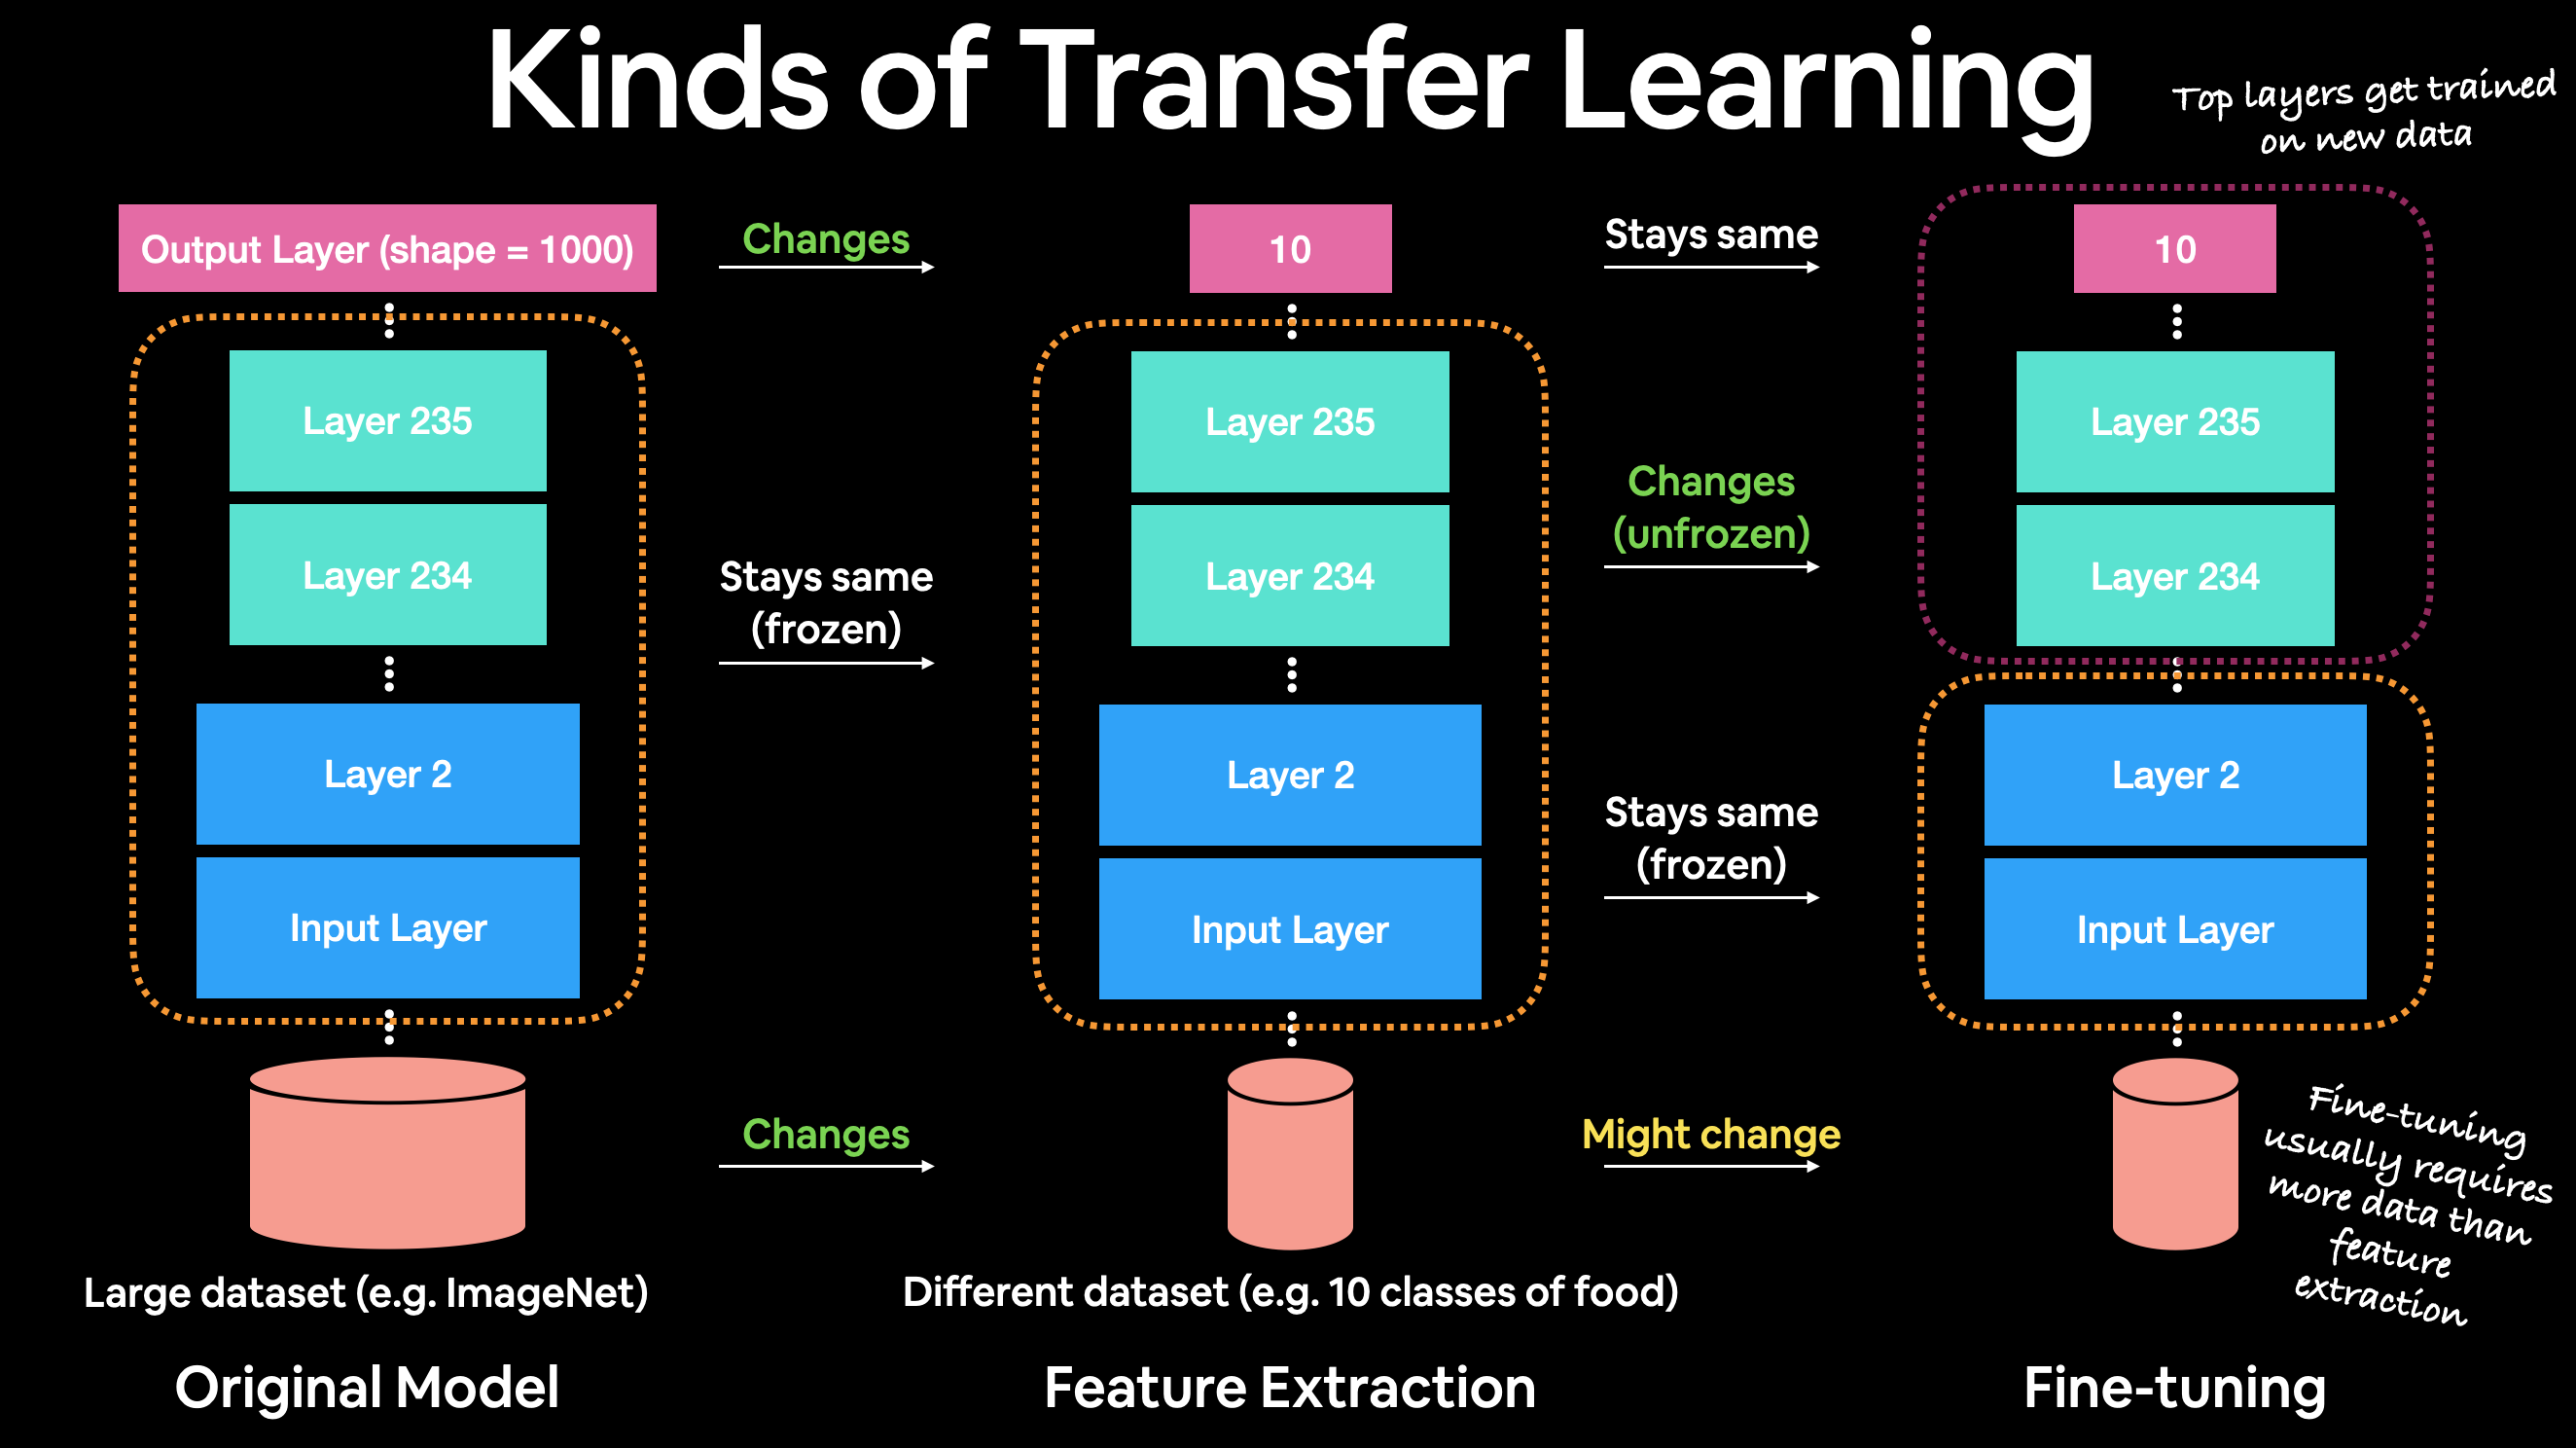

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
import requests

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600/root/.kaggle/kaggle.json

chmod: missing operand after ‘600/root/.kaggle/kaggle.json’
Try 'chmod --help' for more information.


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

100%|██████████| 309M/309M [00:01<00:00, 199MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4


In [6]:
!mv /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4 /content/


In [7]:
train_directory = "/content/4/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/4/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry" , "happy" , "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred', # inferred from the directory structure
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred', # inferred from the directory structure
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [10]:
training_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [12]:
backbone.trainable = False

In [13]:
input = Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3))

x = backbone(input, training = False)
x = GlobalAveragePooling2D()(x)
x = Dense( CONFIGURATION["N_DENSE_1"], activation = "relu")(x)
x = BatchNormalization()(x)
x = Dense( CONFIGURATION["N_DENSE_2"], activation = "relu")(x)
output = Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax")(x)

finetuned_model = Model(input, output)

In [14]:
loss_function = CategoricalCrossentropy()

In [15]:
metrics = [CategoricalAccuracy(name = "accuracy") , TopKCategoricalAccuracy(k=2 , name = "top_k_accuracy")]

In [16]:
finetuned_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss = loss_function, metrics = metrics)

In [17]:
history = finetuned_model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"]*3 , verbose = 1)

Epoch 1/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 97s 244ms/step - accuracy: 0.6467 - loss: 1.0369 - top_k_accuracy: 0.8774 - val_accuracy: 0.7419 - val_loss: 0.6008 - val_top_k_accuracy: 0.9122
Epoch 2/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7571 - loss: 0.5980 - top_k_accuracy: 0.9297 - val_accuracy: 0.7529 - val_loss: 0.5852 - val_top_k_accuracy: 0.9236
Epoch 3/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.7954 - loss: 0.5087 - top_k_accuracy: 0.9490 - val_accuracy: 0.7783 - val_loss: 0.5389 - val_top_k_accuracy: 0.9355
Epoch 4/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8158 - loss: 0.4435 - top_k_accuracy: 0.9531 - val_accuracy: 0.7845 - val_loss: 0.5374 - val_top_k_accuracy: 0.9267
Epoch 5/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8443 - loss: 0.3884 - top_k_accuracy: 0.9674 - val_accuracy: 0.7730 - val_loss: 0.6022 - val_top_k_accuracy: 0.9280
Epoch 6/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.8463 - loss: 0.3

In [19]:
finetuned_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8262 - loss: 0.7797 - top_k_accuracy: 0.9518


[0.7424851059913635, 0.8279192447662354, 0.9534679651260376]

In [25]:
import json

# Evaluate the model
evaluation_results = finetuned_model.evaluate(validation_dataset)

# Create a dictionary of metric names and values
results_dict = dict(zip(finetuned_model.metrics_names, evaluation_results))

# Save to a JSON file
with open("evaluation_results.json", "w") as file:
    json.dump(results_dict, file, indent=4)


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8189 - loss: 0.7804 - top_k_accuracy: 0.9540


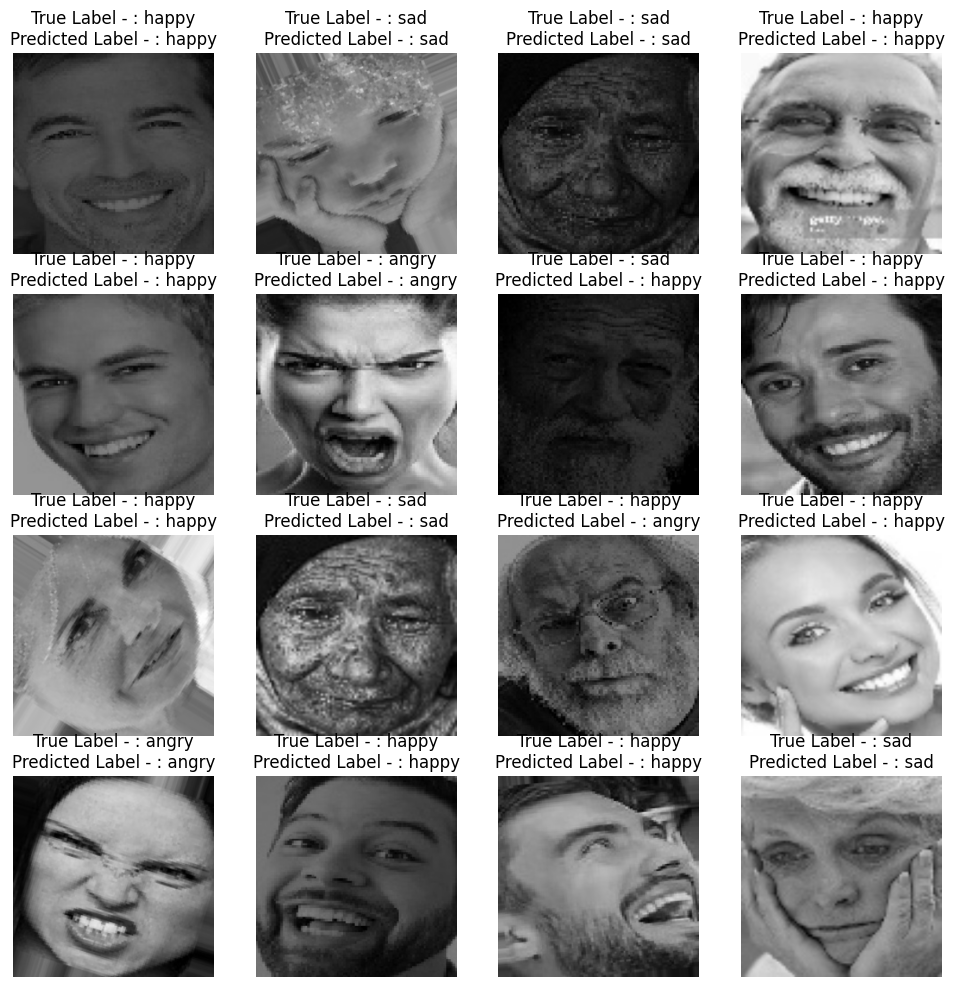

In [27]:
plt.figure(figsize = (12,12))

for images , labels in validation_dataset.take(1):
  for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(images[i]/255)
    plt.title("True Label - : " + CLASS_NAMES[tf.argmax(labels[i] , axis = 0).numpy()] + "\n" + "Predicted Label - : " + CLASS_NAMES[tf.argmax(finetuned_model(tf.expand_dims(images[i],axis=0)) , axis = 1).numpy()[0]])
    plt.axis("off")

## Fine tuning :


In [28]:
backbone.trainable = True

In [29]:
finetuned_model.summary() # look now to the Trainable params

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,584,874 (89.97 MB)

 Trainable params: 19,518,283 (74.46 MB)

 Non-trainable params: 127,255 (497.09 KB)

 Optimizer params: 3,939,336 (15.03 MB)

In [30]:
finetuned_model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]/100), loss = loss_function, metrics = metrics) # make learning rate smaller

In [31]:
# Checkpoint to save the model
model_dir = "/content/models/EfficientNetB4_finetuned"
os.makedirs(model_dir, exist_ok=True)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "EfficientNetB4_finetuned.keras"),
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

In [32]:
history_tuned = finetuned_model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"] , verbose = 1,callbacks=[checkpoint])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 265s 583ms/step - accuracy: 0.6580 - loss: 3.7498 - top_k_accuracy: 0.8713 - val_accuracy: 0.6335 - val_loss: 3.1288 - val_top_k_accuracy: 0.8692
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.6223 - loss: 2.1382 - top_k_accuracy: 0.8701 - val_accuracy: 0.6032 - val_loss: 3.3317 - val_top_k_accuracy: 0.8639
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.6893 - loss: 1.5092 - top_k_accuracy: 0.9041 - val_accuracy: 0.6453 - val_loss: 2.7767 - val_top_k_accuracy: 0.8758
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.7277 - loss: 1.1908 - top_k_accuracy: 0.9199 - val_accuracy: 0.6971 - val_loss: 1.6720 - val_top_k_accuracy: 0.9004
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.7607 - loss: 0.9155 - top_k_accuracy: 0.9303 - val_accuracy: 0.7129 - val_loss: 1.4579 - val_top_k_accuracy: 0.8986
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.7738 

In [33]:
# Extra 20 epochs
history_tuned = finetuned_model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"] , verbose = 1,callbacks=[checkpoint])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.9090 - loss: 0.2250 - top_k_accuracy: 0.9835 - val_accuracy: 0.8020 - val_loss: 0.8835 - val_top_k_accuracy: 0.9390
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.9106 - loss: 0.2277 - top_k_accuracy: 0.9819 - val_accuracy: 0.8077 - val_loss: 0.8840 - val_top_k_accuracy: 0.9377
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.9167 - loss: 0.2273 - top_k_accuracy: 0.9843 - val_accuracy: 0.8090 - val_loss: 0.8838 - val_top_k_accuracy: 0.9394
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.9293 - loss: 0.1738 - top_k_accuracy: 0.9849 - val_accuracy: 0.8099 - val_loss: 0.8978 - val_top_k_accuracy: 0.9368
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.9285 - loss: 0.1878 - top_k_accuracy: 0.9877 - val_accuracy: 0.8108 - val_loss: 0.9084 - val_top_k_accuracy: 0.9394
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.9307 -

In [34]:
# sorry for the play , i wish i fix it 60 from the begining , lets check other 20 epochs
history_tuned = finetuned_model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"] , verbose = 1,callbacks=[checkpoint])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9624 - loss: 0.0989 - top_k_accuracy: 0.9959 - val_accuracy: 0.8389 - val_loss: 0.8978 - val_top_k_accuracy: 0.9447
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.9663 - loss: 0.0838 - top_k_accuracy: 0.9961 - val_accuracy: 0.8420 - val_loss: 0.8981 - val_top_k_accuracy: 0.9460
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - accuracy: 0.9717 - loss: 0.0759 - top_k_accuracy: 0.9970 - val_accuracy: 0.8424 - val_loss: 0.9283 - val_top_k_accuracy: 0.9469
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9725 - loss: 0.0822 - top_k_accuracy: 0.9953 - val_accuracy: 0.8367 - val_loss: 0.9184 - val_top_k_accuracy: 0.9442
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.9648 - loss: 0.0819 - top_k_accuracy: 0.9973 - val_accuracy: 0.8437 - val_loss: 0.9216 - val_top_k_accuracy: 0.9482
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 110ms/step - accuracy: 0.9710 - 

In [35]:
history_tuned = finetuned_model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"] , verbose = 1,callbacks=[checkpoint])

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9787 - loss: 0.0550 - top_k_accuracy: 0.9966 - val_accuracy: 0.8481 - val_loss: 0.9888 - val_top_k_accuracy: 0.9500
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 109ms/step - accuracy: 0.9802 - loss: 0.0478 - top_k_accuracy: 0.9972 - val_accuracy: 0.8551 - val_loss: 0.9524 - val_top_k_accuracy: 0.9543
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 97ms/step - accuracy: 0.9837 - loss: 0.0448 - top_k_accuracy: 0.9983 - val_accuracy: 0.8525 - val_loss: 0.9698 - val_top_k_accuracy: 0.9539
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 23s 108ms/step - accuracy: 0.9807 - loss: 0.0519 - top_k_accuracy: 0.9989 - val_accuracy: 0.8573 - val_loss: 0.9655 - val_top_k_accuracy: 0.9552
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9825 - loss: 0.0418 - top_k_accuracy: 0.9991 - val_accuracy: 0.8565 - val_loss: 0.9934 - val_top_k_accuracy: 0.9548
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.9808 - los

In [36]:
def upload_to_github_release(repo_name, token, tag, file_path, release_name="Model Release"):
    """
    Pushes a file to a GitHub Release.
    Arguments:
        repo_name (str): Repository name in the format "username/repo".
        token (str): GitHub Fine-Grained Personal Access Token.
        tag (str): Release tag (e.g., "v1.0").
        file_path (str): Path to the file to upload.
        release_name (str): Name of the release.
    """
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/vnd.github+json",
    }
    # Step 1: Create a release
    release_url = f"https://api.github.com/repos/Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision/releases"
    release_data = {"tag_name": tag, "name": release_name, "draft": False, "prerelease": False}
    response = requests.post(release_url, headers=headers, json=release_data)
    if response.status_code != 201:
        print("Failed to create release:", response.json())
        return

    release_id = response.json()["id"]
    upload_url = response.json()["upload_url"].split("{")[0]

    # Step 2: Upload the file
    file_name = os.path.basename(file_path)
    with open(file_path, "rb") as f:
        upload_response = requests.post(
            f"{upload_url}?name={file_name}",
            headers=headers,
            files={"file": (file_name, f)},
        )
    if upload_response.status_code == 201:
        print("File successfully uploaded to GitHub Release!")
    else:
        print("Failed to upload file:", upload_response.json())

In [37]:
model_path = os.path.join(model_dir, "EfficientNetB4_finetuned.keras")
github_repo = "Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision"  # Replace with your repo
github_token =  "" # Replace with your Fine-Grained Token
release_tag = "v6.0"  # Specify your release tag
upload_to_github_release(github_repo, github_token, release_tag, model_path , release_name = "Human Emotion Detection-EfficientNetB4_finetuned Model Release")


File successfully uploaded to GitHub Release!


In [38]:
import pickle
import os

# Directory to save the history
history_dir = "/content/models/EfficientNetB4/history_tuned"
os.makedirs(history_dir, exist_ok=True)

# Saving the history object as a pickle file
history_path = os.path.join(history_dir, "training_history.pkl")

# Assuming 'history' is the training history from lenet_model.fit
with open(history_path, "wb") as f:
    pickle.dump(history_tuned.history, f)

print(f"Training history saved at {history_path}")


Training history saved at /content/models/EfficientNetB4/history_tuned/training_history.pkl


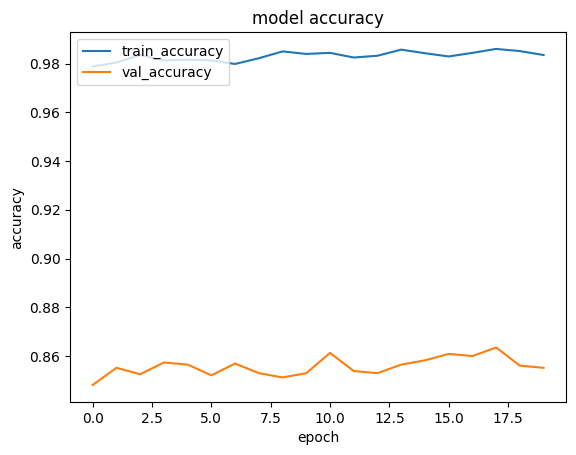

In [51]:
plt.plot(history_tuned.history['accuracy'])
plt.plot(history_tuned.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [55]:
test_image = cv2.imread("/content/4/Emotions Dataset/Emotions Dataset/test/happy/520857.jpg")
test_image = cv2.resize(test_image , (CONFIGURATION["IM_SIZE"] , CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image , dtype = tf.float32)
im = tf.expand_dims(im , axis = 0)
print(finetuned_model(im))
print(CLASS_NAMES[tf.argmax(finetuned_model(im) , axis = 1).numpy()[0]])

tf.Tensor([[6.392190e-13 1.000000e+00 2.026515e-12]], shape=(1, 3), dtype=float32)
happy


# **Conclusion**

Fine-tuning the EfficientNetB4 model significantly enhanced its performance, achieving:

*   **Training Accuracy**: 98.62%
    
*   **Training Top-2 Accuracy**: 99.99%
    
*   **Validation Accuracy**: 86.35%
    
*   **Validation Top-2 Accuracy**: 95.65%
    

These results demonstrate the effectiveness of fine-tuning in leveraging pre-trained knowledge to achieve high accuracy and robust generalization for human emotion detection.